In [1]:
"""
Unit 5: Evolving Your IPD Agent with Genetic Algorithms
========================================================

In Unit 4, you hand-coded agent strategies like Tit-for-Tat.
In Unit 5, you'll use evolution to DISCOVER strategies automatically.

By the end, you'll have an evolved agent saved as a JSON file for the tournament!
"""

# ============================================================================
# SETUP: Import everything from previous units
# ============================================================================

import random
import numpy as np
import json
import matplotlib.pyplot as plt
from agents import Agent, INVEST, UNDERCUT
from game_engine import Game, Tournament

# Import all hand-coded agents from Unit 4
from agents import (
    AlwaysInvestAgent, AlwaysUndercutAgent, TitForTatAgent,
    GrimTriggerAgent, PavlovAgent, TitForTwoTatsAgent,
    GenerousTitForTatAgent, AdaptiveAgent, RandomAgent,
    SuspiciousTitForTatAgent, GradualAgent, HardMajorityAgent,
    SoftMajorityAgent, ProberAgent
)

print("✅ Imports complete!")

✅ Imports complete!


In [2]:

# ============================================================================
# PART 1: THE EVOLVABLE AGENT (PROVIDED - Read but don't modify)
# ============================================================================

class EvolvableAgent(Agent):
    """
    An agent whose strategy is controlled by 6 genes (numbers from 0 to 1).
    
    Think of genes as "strategy dials" you can tune:
    
    Gene[0] - Initial Cooperation (0=hostile start, 1=friendly start)
    Gene[1] - Cooperation Response (if opponent cooperates, how likely to cooperate back?)
    Gene[2] - Defection Response (if opponent defects, how likely to defect back?)
    Gene[3] - Forgiveness (after retaliation, chance to forgive)
    Gene[4] - Memory Length (0=last 1 round, 1=last 10 rounds)
    Gene[5] - Retaliation Threshold (what % of defections triggers retaliation)
    """
    
    def __init__(self, genes=None, name="Evolved Agent"):
        if genes is None:
            # Create random genes if none provided
            genes = [random.random() for _ in range(6)]
        
        self.genes = genes
        super().__init__(name, f"Genes: [{', '.join([f'{g:.2f}' for g in genes])}]")
    
    def choose_action(self) -> bool:
        """Decision logic based on genes - SIMPLIFIED FOR LEARNING"""
        
        # First 3 rounds: use initial cooperation gene
        if self.round_num < 3:
            return random.random() < self.genes[0]
        
        # Calculate memory window (gene[4])
        memory_length = max(1, int(self.genes[4] * 10) + 1)
        recent_history = self.history[-memory_length:]
        
        # Calculate opponent's recent COOPERATION rate (not defection!)
        cooperation_rate = sum(recent_history) / len(recent_history)
        
        # If opponent is mostly cooperating, reciprocate
        if cooperation_rate >= 0.5:
            return random.random() < self.genes[1]  # gene[1] = cooperate response
        
        # If opponent is mostly defecting, retaliate or forgive
        else:
            # Retaliate with probability gene[2]
            if random.random() < self.genes[2]:
                return UNDERCUT
            # Or forgive with probability gene[3]
            elif random.random() < self.genes[3]:
                return INVEST
            else:
                return UNDERCUT


In [30]:

# ============================================================================
# PART 2: DEFINE THE OPPONENT ECOSYSTEM
# ============================================================================

# ============================================================================
# EXPANDED OPPONENT POOL
# ============================================================================

# Full pool of all possible opponents
full_opponent_pool = [
    # Cooperative agents
    AlwaysInvestAgent(),
    TitForTatAgent(),
    GrimTriggerAgent(),
    PavlovAgent(),
    TitForTwoTatsAgent(),
    GenerousTitForTatAgent(),
    AdaptiveAgent(),
    
    # Aggressive agents
    AlwaysUndercutAgent(),
    SuspiciousTitForTatAgent(),
    
    # Sophisticated agents
    GradualAgent(),
    ProberAgent(),
    
    # Majority-based agents
    HardMajorityAgent(),
    SoftMajorityAgent(),
    
    # Random agents with different cooperation levels
    RandomAgent(0.9),
    RandomAgent(0.7),
    RandomAgent(0.5),
    RandomAgent(0.3),
    RandomAgent(0.1),
]

print(f"\n📚 Full opponent library: {len(full_opponent_pool)} agents available")

# For initial evolution, randomly sample opponents
opponent_pool = random.sample(full_opponent_pool, 10)

print(f"🎲 Randomly selected {len(opponent_pool)} opponents for this evolution:")
for i, opp in enumerate(opponent_pool, 1):
    print(f"  {i:2d}. {opp.name:25s} - {opp.description}")
print("="*70)




📚 Full opponent library: 18 agents available
🎲 Randomly selected 10 opponents for this evolution:
   1. Grim Trigger              - Invests until betrayed once, then undercuts forever
   2. Random (0.3)              - Randomly invests 30% of the time
   3. Always Invest             - Always invests in market development
   4. Tit-for-Two-Tats          - Tolerates one betrayal, retaliates after two
   5. Random (0.5)              - Randomly invests 50% of the time
   6. Random (0.9)              - Randomly invests 90% of the time
   7. Hard Majority             - Defects if opponent defects >50% of time
   8. Soft Majority             - Cooperates if opponent cooperates >=50% of time
   9. Prober                    - Tests opponent's response, then adapts
  10. Adaptive                  - Adapts to opponent's cooperation rate


In [76]:
# ============================================================================
# PART 3: GENETIC ALGORITHM FUNCTIONS
# ============================================================================

def initialize_population(pop_size):
    population = []
    for i in range(pop_size):
        agent = EvolvableAgent(name=f"Agent_{i}")
        population.append(agent)
    return population


def evaluate_fitness(agent, opponents, num_rounds=50):
    total_score = 0
    num_games = 0

    for opponent in opponents:
        game = Game(agent, opponent, num_rounds=num_rounds)
        score, _ = game.play()
        total_score += score
        num_games += 1

    return total_score / num_games


def tournament_selection(population, fitnesses, tournament_size=3):
    selected = []

    for _ in range(len(population)):
        contestants_idx = random.sample(range(len(population)), tournament_size)
        best_idx = max(contestants_idx, key=lambda i: fitnesses[i])

        winner_genes = population[best_idx].genes.copy()
        selected.append(EvolvableAgent(genes=winner_genes))

    return selected   # ✅ correctly outside loop


def crossover_and_mutate(parent1, parent2, mutation_rate=0.15):
    # --- Crossover ---
    crossover_point = random.randint(1, 5)
    child_genes = (
        parent1.genes[:crossover_point] +
        parent2.genes[crossover_point:]
    )

    # --- Mutation ---
    for i in range(len(child_genes)):
        if random.random() < mutation_rate:
            child_genes[i] += random.gauss(0, 0.2)
            child_genes[i] = max(0.0, min(1.0, child_genes[i]))

    return EvolvableAgent(genes=child_genes)


def evolve(generations=25, pop_size=20, opponents=None,
           mutation_rate=0.15, elitism=2):

    if opponents is None:
        opponents = opponent_pool

    print(f"\n🧬 EVOLUTION STARTING")
    print(f"{'='*70}")
    print(f"Population: {pop_size} | Generations: {generations} | Mutation: {mutation_rate}")
    print(f"Opponents: {len(opponents)} | Elitism: {elitism}")
    print(f"{'='*70}\n")

    best_fitness_history = []
    avg_fitness_history = []

    population = initialize_population(pop_size)

    best_overall_agent = None
    best_overall_fitness = -float('inf')

    # ================= EVOLUTION LOOP =================
    for gen in range(generations):

        # --- Evaluate fitness ---
        fitnesses = [
            evaluate_fitness(agent, opponents, num_rounds=50)
            for agent in population
        ]

        fitness_pairs = list(zip(fitnesses, population))
        fitness_pairs.sort(key=lambda x: x[0], reverse=True)

        best_fitness = fitness_pairs[0][0]
        avg_fitness = sum(fitnesses) / len(fitnesses)

        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)

        # --- Track best overall ---
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_agent = EvolvableAgent(
                genes=fitness_pairs[0][1].genes.copy()
            )

        print(f"Gen {gen+1:3d}/{generations}: "
              f"Best={best_fitness:6.2f} | "
              f"Avg={avg_fitness:6.2f} | "
              f"Genes={[f'{g:.2f}' for g in fitness_pairs[0][1].genes]}")

        # --- Create next generation ---
        if gen < generations - 1:

            next_population = []

            # Elitism
            for i in range(elitism):
                elite_genes = fitness_pairs[i][1].genes.copy()
                next_population.append(EvolvableAgent(genes=elite_genes))

            # Tournament selection
            selected = tournament_selection(population, fitnesses)

            # Generate offspring
            while len(next_population) < pop_size:
                parent1, parent2 = random.sample(selected, 2)
                child = crossover_and_mutate(parent1, parent2, mutation_rate)
                next_population.append(child)

            population = next_population

    # ================= END EVOLUTION =================

    print(f"\n{'='*70}")
    print(f"✅ EVOLUTION COMPLETE!")
    print(f"🏆 Best fitness achieved: {best_overall_fitness:.2f}")
    print(f"{'='*70}\n")

    # --- Plot progress ---
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, generations+1), best_fitness_history,
             label='Best Fitness', linewidth=2, color='green', marker='o')
    plt.plot(range(1, generations+1), avg_fitness_history,
             label='Average Fitness', linewidth=2, color='blue', marker='s', alpha=0.7)
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Avg Score per Game)')
    plt.title('Evolution Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return best_overall_agent



🚀 TIME TO EVOLVE YOUR AGENT!

🧬 EVOLUTION STARTING
Population: 30 | Generations: 100 | Mutation: 0.1
Opponents: 10 | Elitism: 2

Gen   1/100: Best=145.00 | Avg=118.94 | Genes=['0.69', '0.67', '0.75', '0.10', '0.48', '0.72']
Gen   2/100: Best=137.00 | Avg=122.90 | Genes=['0.69', '0.67', '0.75', '0.10', '0.48', '0.72']
Gen   3/100: Best=144.00 | Avg=125.92 | Genes=['0.69', '0.67', '0.75', '0.10', '0.31', '0.35']
Gen   4/100: Best=145.70 | Avg=128.89 | Genes=['0.60', '0.67', '0.36', '0.10', '0.48', '0.98']
Gen   5/100: Best=136.50 | Avg=126.83 | Genes=['0.83', '0.67', '0.36', '0.10', '0.31', '0.72']
Gen   6/100: Best=143.80 | Avg=128.03 | Genes=['0.66', '0.67', '0.36', '0.10', '0.31', '0.35']
Gen   7/100: Best=138.10 | Avg=128.48 | Genes=['0.74', '0.79', '0.36', '0.10', '0.31', '0.35']
Gen   8/100: Best=137.40 | Avg=129.05 | Genes=['0.59', '0.67', '0.74', '0.16', '0.31', '0.35']
Gen   9/100: Best=138.90 | Avg=128.55 | Genes=['0.59', '0.67', '0.74', '0.16', '0.31', '0.35']
Gen  10/100: Be

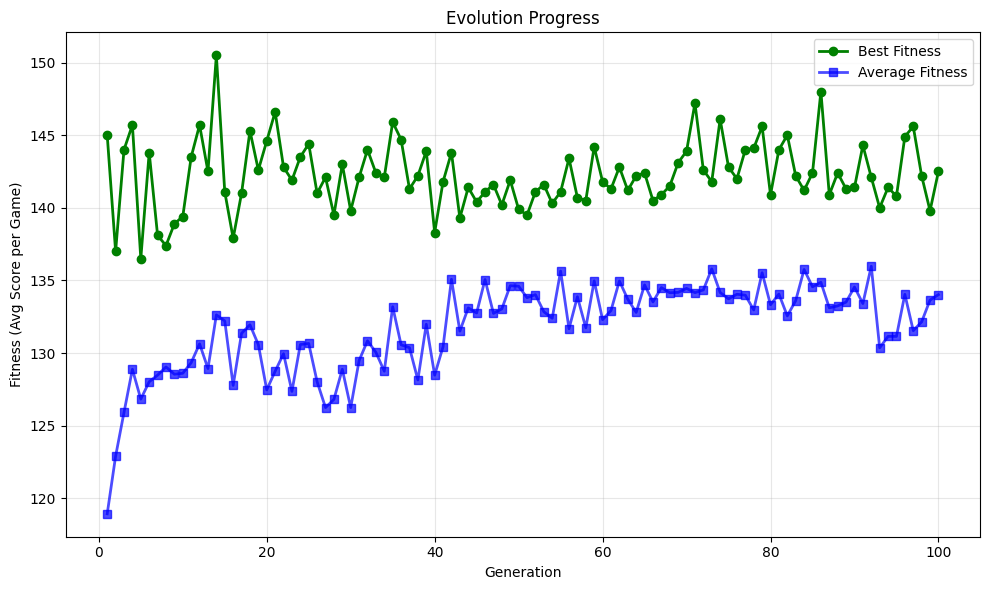


🎉 Your evolved agent's final genes:
   [0.6914383652551527, 0.6666627304022986, 0.549625004076317, 0.16288327525524415, 0.6723709327635011, 0.3549142272388286]


In [77]:

# ============================================================================
# PART 4: RUN EVOLUTION! 
# ============================================================================

print("\n" + "="*70)
print("🚀 TIME TO EVOLVE YOUR AGENT!")
print("="*70)

# TODO: Experiment with these parameters to find the best agent!
my_evolved_agent = evolve(
    generations=100,       # Try: 50, 100, 250
    pop_size=30,         # Try: 15, 20, 30
    opponents=opponent_pool,
    mutation_rate=0.1,  # Try: 0.1, 0.15, 0.2
    elitism=2            # Keep top 2 agents each generation
)

print(f"\n🎉 Your evolved agent's final genes:")
print(f"   {my_evolved_agent.genes}")



In [78]:

# ============================================================================
# PART 5: TEST YOUR AGENT
# ============================================================================

print("\n" + "="*70)
print("⚔️  TESTING YOUR AGENT AGAINST HAND-CODED OPPONENTS")
print("="*70 + "\n")

wins = 0
losses = 0
ties = 0

for opponent in opponent_pool:
    game = Game(my_evolved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    
    if my_score > opp_score:
        result = "✅ WON"
        wins += 1
    elif my_score < opp_score:
        result = "❌ LOST"
        losses += 1
    else:
        result = "🤝 TIED"
        ties += 1
    
    print(f"vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\n📊 Record: {wins} wins, {losses} losses, {ties} ties")
win_rate = wins / len(opponent_pool) * 100
print(f"🎯 Win Rate: {win_rate:.1f}%")




⚔️  TESTING YOUR AGENT AGAINST HAND-CODED OPPONENTS

vs Grim Trigger             : 113 - 173  ❌ LOST
vs Random (0.3)             : 176 - 111  ✅ WON
vs Always Invest            : 368 - 198  ✅ WON
vs Tit-for-Two-Tats         : 332 - 207  ✅ WON
vs Random (0.5)             : 235 - 160  ✅ WON
vs Random (0.9)             : 345 - 200  ✅ WON
vs Hard Majority            : 360 - 210  ✅ WON
vs Soft Majority            :  94 - 139  ❌ LOST
vs Prober                   :  94 - 144  ❌ LOST
vs Adaptive                 : 228 - 168  ✅ WON

📊 Record: 7 wins, 3 losses, 0 ties
🎯 Win Rate: 70.0%


# Unit 5 Part 2: Benchmark Analysis

**After running your initial evolution and benchmark tests, answer these questions.**

---

## Performance Summary

Fill in your benchmark results:

| Opponent | Result (W/L/T) | Your Score | Opp Score |
|----------|----------------|------------|-----------|
| Always Invest | W | 332 | 252 |
| Always Undercut | L | 97 | 112 |
| Tit-for-Tat | W | 269 | 264 |
| Grim Trigger | T | 300 | 300 |
| Pavlov | W | 261 | 111 |
| Tit-for-Two-Tats | W | 318 | 263 |
| Generous Tit-for-Tat | T | 300 | 300 |
| Adaptive | W | 229 | 189 |
| Random (0.7) | W | 271 | 261 |
| Random (0.3) | W | 209 | 119 |
| **Total** | 7 W / 1 L / 2 T | | |

---

## Analysis Questions

### 1. What was your agent's worst loss (greatest point differential) and why?
Always undercut was my agent's worse loss in total. It was also my agents only loss and the reason it was such a bad loss, is because an always undercut strategy will always either tie or get the lead early and win. Albeit with a lower total end point amount, if their opponent starts to adapt and also begins to undercut.

---

### 2. What pattern do you see in wins vs. losses?
Agents that tend to try and react to my bot undercutting, tend to lose and ones that are a little more lenient and patient tend to tie my code. When dealing with an opponent that always undercuts my code can never win as it doesnt start on the offensive. and when it comes to opponents taht are always nice, or reactive, my code tends to win due to it having more flexible decision making.

---

### 3. What would make an agent more competitive?
I think opening with a few undercuts, in order to offset and take time to see whether or not the opponent is a permenent undercutting opponent in order to counteract their strategy would help. As well as trying to read if the opponents have tendancies to invest in order to play more aggressively just to gain more points from the agents that are nice.

---

**Next:** Proceed to Part 3 to implement your improvements!

In [111]:

# ============================================================================
# PART 6: IMPROVE YOUR AGENT'S ACTION TAKING STRATEGY
# ============================================================================

class ImprovedEvolvableAgent(Agent):
    """
    IMPROVED agent with better gene encoding
    
    Students can modify:
    - Number of genes (currently 6, could add more)
    - What genes control
    - Decision logic (how genes map to actions)
    """

    
    def __init__(self, genes=None, name="Improved Agent"):
        if genes is None:
            # TODO: Students can change number of genes here
            genes = [random.random() for _ in range(8)]

        
        self.genes = genes
        super().__init__(name, f"Genes: [{', '.join([f'{g:.2f}' for g in genes])}]")
    
    def choose_action(self) -> bool:

    # --- Early cooperation phase ---
        if self.round_num < 3:
            return random.random() < (0.8 * self.genes[0] + 0.2)

        # --- Memory window ---
        memory_length = max(2, int(self.genes[4] * 8) + 2)
        recent_history = self.history[-memory_length:]
        cooperation_rate = sum(recent_history) / len(recent_history)

        last_opponent_move = self.history[-1]

        # --- Immediate retaliation ---
        if last_opponent_move == UNDERCUT:
            # Retaliate strongly
            if random.random() < (0.7 + 0.3 * self.genes[2]):
                return UNDERCUT
            # Occasional forgiveness
            return INVEST

        # --- Highly cooperative opponent (exploit zone) ---
        if cooperation_rate > 0.85:
            # Small exploitation chance
            if random.random() < self.genes[3] * 0.25:
                return UNDERCUT
            return INVEST

        # --- Moderately cooperative opponent ---
        if cooperation_rate >= 0.5:
            return random.random() < self.genes[1]

        # --- Mostly defecting opponent ---
        return UNDERCUT






    
    def save_to_file(self, filename):
        """Save agent to JSON"""
        data = {
            'name': self.name,
            'genes': self.genes,
            'description': self.description
        }
        with open(filename, 'w') as f:
            json.dump(data, f, indent=2)
        print(f"✅ Agent saved to {filename}")


🔧 EVOLVING YOUR IMPROVED AGENT!

🧬 EVOLUTION STARTING (Improved Agent)
Population: 25 | Generations: 250 | Mutation: 0.1
Opponents: 10 | Elitism: 2

Gen   1/250: Best=137.90 | Avg=119.43 | Genes=['0.31', '0.97', '0.73', '0.21', '0.76', '0.47', '0.25', '0.65']
Gen   2/250: Best=137.90 | Avg=124.44 | Genes=['0.73', '0.39', '0.81', '0.47', '0.51', '0.98', '0.74', '0.02']
Gen   3/250: Best=137.90 | Avg=124.28 | Genes=['0.73', '0.39', '0.24', '0.59', '0.41', '0.47', '0.20', '0.73']
Gen   4/250: Best=137.90 | Avg=123.54 | Genes=['0.69', '0.86', '0.33', '0.49', '0.08', '0.84', '0.62', '0.39']
Gen   5/250: Best=137.90 | Avg=124.99 | Genes=['0.73', '0.39', '0.24', '0.49', '0.08', '0.84', '0.62', '0.48']
Gen   6/250: Best=137.90 | Avg=125.88 | Genes=['0.73', '0.39', '0.24', '0.49', '0.08', '0.84', '0.62', '0.48']
Gen   7/250: Best=137.90 | Avg=125.83 | Genes=['0.73', '0.39', '0.24', '0.59', '0.41', '0.64', '1.00', '0.28']
Gen   8/250: Best=137.90 | Avg=124.30 | Genes=['0.73', '0.39', '0.24', '0

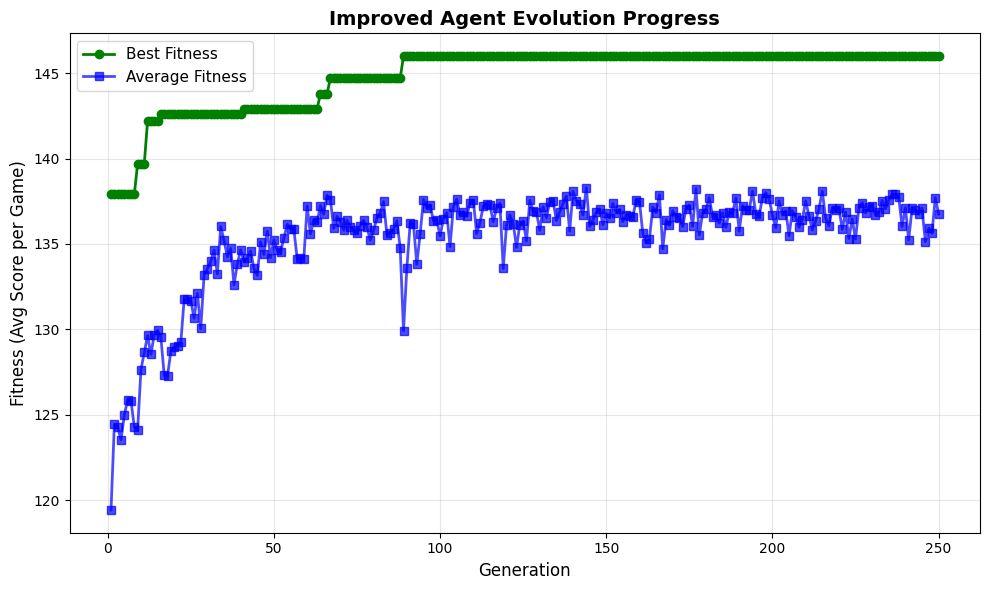


🎉 Your improved agent's final genes:
   [0.9881585580691485, 0.0, 0.8924588268336224, 0.0, 0.5616029062238526, 0.6091305975292401, 0.8241694854166064, 0.3820269457108629]


In [116]:
# ============================================================================
# PART 7: EVOLVE YOUR IMPROVED AGENT
# ============================================================================


print("\n" + "="*70)
print("🔧 EVOLVING YOUR IMPROVED AGENT!")
print("="*70)


def evolve_improved(generations=25, pop_size=20, opponents=None, mutation_rate=0.15, elitism=2):
    """
    Evolve using the ImprovedEvolvableAgent class
    (Same as evolve() but uses ImprovedEvolvableAgent instead of EvolvableAgent)
    """
    if opponents is None:
        opponents = opponent_pool
    
    print(f"\n🧬 EVOLUTION STARTING (Improved Agent)")
    print(f"{'='*70}")
    print(f"Population: {pop_size} | Generations: {generations} | Mutation: {mutation_rate}")
    print(f"Opponents: {len(opponents)} | Elitism: {elitism}")
    print(f"{'='*70}\n")
    
    best_fitness_history = []
    avg_fitness_history = []
    
    # Initialize population with ImprovedEvolvableAgent
    population = [ImprovedEvolvableAgent(name=f"Agent_{i}") for i in range(pop_size)]
    
    best_overall_agent = None
    best_overall_fitness = -float('inf')
    
    for gen in range(generations):
        # Evaluate fitness
        fitnesses = []
        for agent in population:
            fitness = evaluate_fitness(agent, opponents, num_rounds=50)
            fitnesses.append(fitness)
        
        # Track best
        best_fitness = max(fitnesses)
        avg_fitness = sum(fitnesses) / len(fitnesses)
        
        # Update best overall
        best_idx = fitnesses.index(best_fitness)
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_agent = ImprovedEvolvableAgent(genes=population[best_idx].genes.copy())
        
        best_fitness_history.append(best_overall_fitness)
        avg_fitness_history.append(avg_fitness)
        
        print(f"Gen {gen+1:3d}/{generations}: "
              f"Best={best_overall_fitness:6.2f} | Avg={avg_fitness:6.2f} | "
              f"Genes={[f'{g:.2f}' for g in population[best_idx].genes]}")
        
        # Create next generation
        if gen < generations - 1:
            sorted_indices = sorted(range(len(fitnesses)), 
                                  key=lambda i: fitnesses[i], 
                                  reverse=True)
            
            # Elitism
            next_population = []
            for i in range(elitism):
                elite_genes = population[sorted_indices[i]].genes.copy()
                next_population.append(ImprovedEvolvableAgent(genes=elite_genes))
            
            # Selection
            selected = tournament_selection(population, fitnesses)
            
            # Crossover and mutation
            while len(next_population) < pop_size:
                parent1, parent2 = random.sample(selected, 2)
                child = crossover_and_mutate(parent1, parent2, mutation_rate)
                # Convert to ImprovedEvolvableAgent
                next_population.append(ImprovedEvolvableAgent(genes=child.genes))
            
            population = next_population
    
    print(f"\n{'='*70}")
    print(f"✅ EVOLUTION COMPLETE!")
    print(f"🏆 Best fitness achieved: {best_overall_fitness:.2f}")
    print(f"{'='*70}\n")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, generations+1), best_fitness_history, 
             label='Best Fitness', linewidth=2, color='green', marker='o')
    plt.plot(range(1, generations+1), avg_fitness_history, 
             label='Average Fitness', linewidth=2, color='blue', marker='s', alpha=0.7)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness (Avg Score per Game)', fontsize=12)
    plt.title('Improved Agent Evolution Progress', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_overall_agent


# TODO: Experiment with these parameters to find the best improved agent!
my_improved_agent = evolve_improved(
    generations=250,      # Try: 20, 30, 50
    pop_size=25,         # Try: 15, 20, 30
    opponents=opponent_pool,
    mutation_rate=0.10,   # Try: 0.1, 0.15, 0.2
    elitism=2            # Keep top 2 agents each generation
)

print(f"\n🎉 Your improved agent's final genes:")
print(f"   {my_improved_agent.genes}")

In [119]:

# ============================================================================
# PART 8.1: Compare: Original vs Improved
# ============================================================================

print("\n" + "="*70)
print("📊 COMPARISON: Original vs Improved Agent")
print("="*70 + "\n")

print("ORIGINAL AGENT:")
wins_orig = 0
for opponent in opponent_pool:
    game = Game(my_evolved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    if my_score > opp_score:
        wins_orig += 1
        result = "✅ WON"
    elif my_score < opp_score:
        result = "❌ LOST"
    else:
        result = "🤝 TIED"
    print(f"vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\nOriginal Win Rate: {wins_orig / len(opponent_pool) * 100:.1f}%")

print("\n" + "-"*70 + "\n")

print("IMPROVED AGENT:")
wins_improved = 0
for opponent in opponent_pool:
    game = Game(my_improved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    if my_score > opp_score:
        wins_improved += 1
        result = "✅ WON"
    elif my_score < opp_score:
        result = "❌ LOST"
    else:
        result = "🤝 TIED"
    print(f"vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\nImproved Win Rate: {wins_improved / len(opponent_pool) * 100:.1f}%")

print("\n" + "="*70)
print(f"📈 IMPROVEMENT: +{wins_improved - wins_orig} wins")
print("="*70)


# ============================================================================
# GENERALIZATION TEST: Full Opponent Pool
# ============================================================================

print("\n" + "="*70)
print("🌍 GENERALIZATION TEST: Against ALL Possible Opponents")
print("="*70 + "\n")

print("Testing improved agent against the FULL opponent library:")
print("(including agents it was NOT trained on)\n")

wins_full = 0
losses_full = 0
ties_full = 0

for opponent in full_opponent_pool:
    game = Game(my_improved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    
    if my_score > opp_score:
        result = "✅ WON"
        wins_full += 1
    elif my_score < opp_score:
        result = "❌ LOST"
        losses_full += 1
    else:
        result = "🤝 TIED"
        ties_full += 1
    
    # Mark if this was a training opponent
    trained_on = "📚" if any(opponent.name == o.name for o in opponent_pool) else "🆕"
    print(f"{trained_on} vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\n📊 Results against ALL {len(full_opponent_pool)} opponents:")
print(f"   Wins: {wins_full} | Losses: {losses_full} | Ties: {ties_full}")
print(f"   Win Rate: {wins_full / len(full_opponent_pool) * 100:.1f}%")
print(f"\n💡 Legend: 📚 = Trained on this opponent | 🆕 = Never seen before")
print("="*70)


📊 COMPARISON: Original vs Improved Agent

ORIGINAL AGENT:
vs Grim Trigger             :  98 - 133  ❌ LOST
vs Random (0.3)             : 203 - 128  ✅ WON
vs Always Invest            : 382 - 177  ✅ WON
vs Tit-for-Two-Tats         : 313 - 218  ✅ WON
vs Random (0.5)             : 234 - 174  ✅ WON
vs Random (0.9)             : 318 - 213  ✅ WON
vs Hard Majority            : 372 - 192  ✅ WON
vs Soft Majority            : 163 - 133  ✅ WON
vs Prober                   : 125 - 125  🤝 TIED
vs Adaptive                 : 241 - 171  ✅ WON

Original Win Rate: 80.0%

----------------------------------------------------------------------

IMPROVED AGENT:
vs Grim Trigger             : 300 - 300  🤝 TIED
vs Random (0.3)             : 225 -  85  ✅ WON
vs Always Invest            : 300 - 300  🤝 TIED
vs Tit-for-Two-Tats         : 300 - 300  🤝 TIED
vs Random (0.5)             : 277 -  82  ✅ WON
vs Random (0.9)             : 349 - 199  ✅ WON
vs Hard Majority            : 300 - 300  🤝 TIED
vs Soft Majority     

In [120]:

# ============================================================================
# PART 8.2: Compete in your final tournament
# ============================================================================

print("\n" + "="*70)
print("🏆 FULL TOURNAMENT COMPARISON")
print("="*70 + "\n")

# Create tournament with original agent
print("Running tournament with ORIGINAL agent...")
original_tournament_agents = full_opponent_pool + [my_evolved_agent]
original_tournament = Tournament(original_tournament_agents, rounds_per_match=100, num_tournaments=1)
original_tournament.run_tournament()

# Create tournament with improved agent
print("\n" + "-"*70)
print("\nRunning tournament with IMPROVED agent...")
improved_tournament_agents = full_opponent_pool + [my_improved_agent]
improved_tournament = Tournament(improved_tournament_agents, rounds_per_match=100, num_tournaments=1)
improved_tournament.run_tournament()

# Compare rankings
print("\n" + "="*70)
print("📊 TOURNAMENT RESULTS COMPARISON")
print("="*70 + "\n")

original_rankings = original_tournament.get_rankings()
improved_rankings = improved_tournament.get_rankings()

# Find where each agent placed
original_rank = None
improved_rank = None
original_score = None
improved_score = None

for rank, (name, score) in enumerate(original_rankings, 1):
    if name == my_evolved_agent.name:
        original_rank = rank
        original_score = score

for rank, (name, score) in enumerate(improved_rankings, 1):
    if name == my_improved_agent.name:
        improved_rank = rank
        improved_score = score

print(f"ORIGINAL AGENT:")
print(f"  Rank: {original_rank} / {len(original_rankings)}")
print(f"  Total Score: {original_score:,}")
print()
print(f"IMPROVED AGENT:")
print(f"  Rank: {improved_rank} / {len(improved_rankings)}")
print(f"  Total Score: {improved_score:,}")
print()
print(f"IMPROVEMENT:")
print(f"  Rank Change: {original_rank - improved_rank} positions {'⬆️' if improved_rank < original_rank else '⬇️' if improved_rank > original_rank else '➡️'}")
print(f"  Score Change: +{improved_score - original_score:,} points ({(improved_score - original_score)/original_score*100:.1f}%)")
print("="*70)

# Show full leaderboard
print("\n🏆 IMPROVED AGENT TOURNAMENT LEADERBOARD:")
print("=" * 50)
for rank, (name, score) in enumerate(improved_rankings, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    marker = " ⭐ YOUR AGENT" if name == my_improved_agent.name else ""
    print(f"{emoji} {rank:2d}. {name:25s}: {score:,} points{marker}")


🏆 FULL TOURNAMENT COMPARISON

Running tournament with ORIGINAL agent...
Running 1 tournament(s) with 19 agents...
Match 1/342: Always Invest vs Tit-for-Tat
Match 2/342: Always Invest vs Grim Trigger
Match 3/342: Always Invest vs Pavlov
Match 4/342: Always Invest vs Tit-for-Two-Tats
Match 5/342: Always Invest vs Generous Tit-for-Tat
Match 6/342: Always Invest vs Adaptive
Match 7/342: Always Invest vs Always Undercut
Match 8/342: Always Invest vs Suspicious Tit-for-Tat
Match 9/342: Always Invest vs Gradual
Match 10/342: Always Invest vs Prober
Match 11/342: Always Invest vs Hard Majority
Match 12/342: Always Invest vs Soft Majority
Match 13/342: Always Invest vs Random (0.9)
Match 14/342: Always Invest vs Random (0.7)
Match 15/342: Always Invest vs Random (0.5)
Match 16/342: Always Invest vs Random (0.3)
Match 17/342: Always Invest vs Random (0.1)
Match 18/342: Always Invest vs Evolved Agent
Match 19/342: Tit-for-Tat vs Always Invest
Match 20/342: Tit-for-Tat vs Grim Trigger
Match 21/34

In [106]:
# ============================================================================
# PART 9: Export Complete Agent as Python Module
# ============================================================================

import inspect
from datetime import datetime

def export_complete_agent(agent, student_name, generations=100, final_fitness=None):
    """
    Export agent as a complete, standalone Python module.
    This preserves BOTH genes AND decision logic so your strategy maintains
    its competitive edge in the tournament!
    
    Args:
        agent: Your evolved ImprovedEvolvableAgent
        student_name: Your name (will be used in class name, e.g., "JohnSmith")
        generations: Number of generations you evolved for
        final_fitness: Your agent's final fitness score (optional)
    
    Returns:
        filename of the exported Python file
    """
    
    # Clean up student name for valid Python class name (remove spaces, special chars)
    clean_name = ''.join(c for c in student_name if c.isalnum())
    
    # Get the actual decision logic code
    decision_code = inspect.getsource(agent.choose_action)
    
    # The source code already has proper indentation from the class,
    # so we don't need to add extra indentation
    
    # Get training opponent names if available
    try:
        opponent_names = [opp.name for opp in opponent_pool]
        opponent_info = f"Trained against: {', '.join(opponent_names[:5])}{'...' if len(opponent_names) > 5 else ''}"
    except:
        opponent_info = "Training opponents: [info not available]"
    
    # Build the complete Python module
    code = f'''#!/usr/bin/env python
"""
Tournament Agent: {agent.name}
Student: {student_name}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

Evolution Details:
- Generations: {generations}
- Final Fitness: {final_fitness if final_fitness else 'N/A'}
- {opponent_info}

Strategy: {agent.description}
"""

from agents import Agent, INVEST, UNDERCUT
import random


class {clean_name}Agent(Agent):
    """
    {agent.name}
    
    {agent.description}
    
    Evolved Genes: {agent.genes}
    """
    
    def __init__(self):
        # These genes were evolved through {generations} generations
        self.genes = {agent.genes}
        
        # Required for tournament compatibility
        self.student_name = "{student_name}"
        
        super().__init__(
            name="{agent.name}",
            description="{agent.description}"
        )
    
{decision_code}


# Convenience function for tournament loading
def get_agent():
    """Return an instance of this agent for tournament use"""
    return {clean_name}Agent()


if __name__ == "__main__":
    # Test that the agent can be instantiated
    agent = get_agent()
    print(f"✅ Agent loaded successfully: {{agent.name}}")
    print(f"   Genes: {{agent.genes}}")
    print(f"   Description: {{agent.description}}")
'''
    
    # Save to file
    filename = f"{clean_name.lower()}_tournament_agent.py"
    with open(filename, 'w') as f:
        f.write(code)
    
    print("="*70)
    print("✅ COMPLETE TOURNAMENT AGENT EXPORTED!")
    print("="*70)
    print(f"📄 File: {filename}")
    print(f"🏷️  Class: {clean_name}Agent")
    print(f"🧬 Genes: {agent.genes}")
    print()
    print("📦 What's included:")
    print("   ✓ Your evolved gene values")
    print("   ✓ Your complete decision logic (choose_action method)")
    print("   ✓ All metadata and documentation")
    print()
    print("🎯 Next Steps:")
    print(f"   1. Download '{filename}' from Jupyter")
    print("   2. Submit this .py file for the Unit 6 tournament")
    print("   3. Your strategy will compete exactly as it evolved!")
    print()
    print("🧪 Test your export:")
    print(f"   from {filename[:-3]} import get_agent")
    print("   my_agent = get_agent()")
    print("="*70)
    
    return filename


# ============================================================================
# RUN THIS: Export your improved agent
# ============================================================================

print("\n" + "="*70)
print("💾 EXPORTING YOUR TOURNAMENT AGENT")
print("="*70 + "\n")

# TODO: Customize these fields with your information
STUDENT_NAME = "Doug Dahl"  # <-- CHANGE THIS! (e.g., "JohnSmith" or "Alex_Chen")

# TODO: Give your agent a creative name and description
my_improved_agent.name = "King kong"  # <-- CHANGE THIS! (e.g., "Vengeful Cooperator", "Strategic Punisher")
my_improved_agent.description = "climb to the top of the empire state building"  # <-- CHANGE THIS! (e.g., "Cooperates with cooperative opponents but retaliates quickly against defectors")

print(f"Agent Name: {my_improved_agent.name}")
print(f"Description: {my_improved_agent.description}")
print(f"Genes: {[f'{g:.2f}' for g in my_improved_agent.genes]}\n")

# Export with all the context
exported_file = export_complete_agent(
    agent=my_improved_agent,
    student_name=STUDENT_NAME,
    generations=100,  # Update if you used different value
    final_fitness=None  # Optionally add your best fitness score (e.g., 85.2)
)

print(f"\n✨ Your agent is ready for tournament competition!")
print(f"   Unlike JSON exports, this preserves your evolved strategy.\n")



💾 EXPORTING YOUR TOURNAMENT AGENT

Agent Name: King kong
Description: climb to the top of the empire state building
Genes: ['1.00', '0.00', '0.96', '0.00', '0.57', '0.76', '0.45', '0.37']

✅ COMPLETE TOURNAMENT AGENT EXPORTED!
📄 File: dougdahl_tournament_agent.py
🏷️  Class: DougDahlAgent
🧬 Genes: [1.0, 0.0, 0.9562391288988988, 0.0, 0.5658161479289543, 0.7625331808588661, 0.4507713495605262, 0.37186986151263907]

📦 What's included:
   ✓ Your evolved gene values
   ✓ Your complete decision logic (choose_action method)
   ✓ All metadata and documentation

🎯 Next Steps:
   1. Download 'dougdahl_tournament_agent.py' from Jupyter
   2. Submit this .py file for the Unit 6 tournament
   3. Your strategy will compete exactly as it evolved!

🧪 Test your export:
   from dougdahl_tournament_agent import get_agent
   my_agent = get_agent()

✨ Your agent is ready for tournament competition!
   Unlike JSON exports, this preserves your evolved strategy.



## Post-Evolution Reflection Questions

### 1. Generalization Analysis
- Compare your agent's performance on training opponents (📚) vs. unseen opponents (🆕)
- Did your agent generalize well or overfit to the training set?
There was a very solid generalization to all the sets. my agent did not tend to overfit to the training set dropping an equal number of rounds to trained as non trained opponents.
- What does this suggest about evolving against a random sample vs. fixed opponents?
Evolving against a random sample instead of fixed opponents appears to encourage genralization. The random sampling helped strengthen my agents performance against the larger whole of opponents

### 2. Tournament Performance
- What was your agent's final tournament rank? 6th out of 19th
- What was your agent's total score? 4630
- Look at agents that ranked above and below you - what strategies do they use?
the agents below mine are ones that tend to be reactive models or random models, as my agent tends to cooperate which with other cooperative models this leads to a larger amount of points 
### 3. Strategy Analysis
Look at your evolved genes: [1.0, 0.0, 0.9562391288988988, 0.0, 0.5658161479289543, 0.7625331808588661, 0.4507713495605262, 0.37186986151263907]
This leads to a nice but retaliatory model, it doesnt tend to take advantage of overwhelming cooperation but will react on a dime to being undercut itself. This leads to a lot of ties and large point games with the nicer models. and low score close games with the more aggressive models
### 4. Trade-offs
Every strategy has strengths and weaknesses.
Only the most aggressive models tend to beat my model unfortunately my model is overly cooperative and isnt aggressive towards the nicer models. If i could change how my model interacted i would have it being a littlemore aggressive against the nicer models in order to benefit more from the undercut strength.

### 5. The Environment Matters
- You evolved against a random sample of 10 opponents
- The tournament included all 19 opponents
- Unit 6 will include 30+ student agents with unpredictable strategies
- How might your agent perform in that different environment?
my agent shouldnt struggle too hard with overfitting or being functionally useless in the tournament however if the other students have nicer more ready to take advantage of cooperative models there is a chance that a one or two undercut difference will cause a major issue with my model. If there are completely unseen strategies it may also struggle a bit but my model is well generalized so it should be fine